# Neural Radiance Fields for Drones

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S76_drone_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from dataclasses import dataclass
import numpy as np
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import gtbook.stonehenge as stonehenge

WHITE = torch.tensor([1,1,1], dtype=torch.float32 )
BLUE = torch.tensor([0,0,1], dtype=torch.float32 )

try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"


DEVICE = (
    torch.device("cuda") if torch.cuda.is_available()
    # else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print(f"Using device: {DEVICE}")

Using device: cpu


```{index} learning; neural radiance fields
```

> Learning 3D scene representations from images.

<img src="Figures7/S76-Autonomous_camera_drone-06.jpg" alt="Splash image with a drone-like robot, steampunk style" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

## What is a NeRF?

> NeRFs represent 3D scenes to render new views.

In this section we will examine how to learn 3D representations from image data. In the previous section we have seen how a cost function derived from an occupancy map can assist in planning drone trajectories while avoiding obstacles. This begs the question what to do when flying into a new environment. We have previously, in Section 7.4, discussed sparse Structure from Motion (SfM), but this does not yield a dense representation that can be used for planning. In this section we take a deeper look at a recent learning-based method to do just that.

```{index} pair: neural radiance field; NeRF
```

A **neural radiance field** or "NeRF" is a neural representation of a 3D scene which is useful for drones to help with motion planning, obstacle avoidance, or even simply simulation of drone flights. NeRFs are a novel, data-driven solution to the long-standing problem in computer graphics of the realistic rendering of virtual worlds. They were introduced in the field of computer vision in 2020 by a team of researchers from Berkeley and Google, and have since seen an explosion of interest, including in the field of robotics. The field is evolving rapidly, and this section necessarily presents a snapshot in time, but we discuss some of the core ideas that will hopefully stand the test of time.

<figure id="fig:NeRF-setup"> 
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures7/NeRF-setup.png?raw=1" style="width:16cm" alt="">
<figcaption>A NeRF stores a volumetric scene representation as the weights of a neural network, trained on many images with known pose.</figcaption>
</figure>

The original 2020 NeRF paper by Mildenhall et al. {cite:p}`Mildenhall22eccv_Nerf` does an excellent job of explaining the basics.
Figure [1](#fig:NeRF-setup), from that paper, describes the setup: given a set of input images, with *known* camera pose and intrinsics calibration, a representation is learned that encodes the scene.
The original NeRF paper defines a large neural network that can be trained to predict the value of every pixel in any image that could be acquired by a camera viewing the scene. By doing so, the neural network can then also *generate* new images that are not in the original training set. What is more, the neural network can also be used to predict the 3D structure of the underlying scene, making it possible to do much more than simply view synthesis.

The original NeRF work has introduced a new way to infer 3D scenes from images, and is influential because:

- the proposed scheme of learning a neural representation of the 3D scene was very simple;
- the resulting NeRFs were capable of generating very realistic "renderings" of the learned scene.

While the original NeRF paper was rather slow because of the large neural network, since then faster *voxel-based* versions have been developed. We work with those variants, making it possible to train your own NeRF-like representation within a notebook.
In particular, below we extend the 1D interpolation example from Chapter 5 to interpolating in 3D voxel space, and show that this can be used to create a neural *radiance* field. However, we first need to talk about volume rendering, the basic math underlying all of this.

## Volume Rendering

> Integrating color over a volume, weighted by density.

```{index} volume rendering
```
The key technique in NeRF is **volume rendering**, a class of methods that generate images by tracing a ray into the scene and taking an integral of some sort over the length of the ray. In the original NeRF, a multi-layer perceptron is used to encode a function from the 3D coordinates on the ray to quantities like density and color, which are integrated to yield an image.

<figure id="fig:NeRF-pipeline"> 
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures7/NeRF-pipeline.png?raw=1" style="width:16cm" alt="">
<figcaption>New views are rendered by integrating the density and color at regular intervals along each viewing ray.</figcaption>
</figure>


Figure [2](#fig:NeRF-pipeline) sketches out how volume rendering works. On the left, for *every* pixel you want to render, a ray is projected into the 3D volume of interest (here represented by a cube) and sampled 3D point locations are defined along this ray. For every sample, the neural network $F_\Theta$ is queried for both a local *density* $\delta$ and a *color* $c$. The colors are then integrated along the ray, with local color contributions weighted by the local density, to yield a final pixel color.

To get some intuition, think about where high density regions will exist for the simple example scene shown. Here, we expect the density to be high on the *surface* of the object - the lego excavator toy in this example. If that is the only high-density area on the ray, the pixel corresponding to that ray will just use the color from that high-density surface. However, the integration scheme, which we implement below, is also able to account for occlusions or even semi-transparency.

### Sampling from Rays

The first part of a volume renderer is to evenly sample points on rays that emanate from the optical center of a camera. When we are given the origin and the direction of a ray (as a unit vector) sampling is simple enough: a point $P$ on the ray at a distance $t$ from the origin $O$, in the direction $D$ is given as
\begin{equation}
P(t,O,D) = O + t  D
\end{equation}
where $t$ is the along the ray. Hence, we only need to sample many $t$ values evenly and we are done. 

We will be implementing volume rendering by making use of the Pytorch library, to ensure we can efficiently handle many thousands of rays in parallel. A lot of the parallel processing that happens on the GPU is handled transparently, which is a key driver behind the deep learning revolution.
As a case in point, our first function `sample_along_ray` below takes a set of t_values and produces the corresponding sampled points $P$:

In [4]:
def sample_along_ray(t_values, origins, directions):
    """Sample points along rays defined by origins and (unit-norm) directions."""
    return origins[..., None, :] + t_values[:, None] * directions[..., None, :]

This function takes three Pytorch tensors: the t-values, the ray origins, and the ray directions. Note that we took care to implement it so it can handle *arbitrary* batches of origin/direction pairs, although we expect the last dimension of ray origins and directions to be 3. PyTorch broadcasting rules will take care to appropriately expand the array of t-values. Correct batch handling is not as easy and might require you to delve into the [Pytorch documentation](https://pytorch.org/docs/). To help understanding, let us look at a small illustrative example where we sample two rays in parallel:

In [5]:
t_values = torch.linspace(0.0, 1.0, 25) # 25 points along each ray
origins = torch.tensor([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]) # same origin.
directions = torch.tensor([[1.0, 0.0, 0.0], [np.cos(0.3), np.sin(0.3), 0.0]])

samples = sample_along_ray(t_values, origins, directions)

assert samples.shape == torch.Size([2, 25, 3])

The last line above asserts that we sampled 2 rays for 25 different $t$-values, for a total of 50 three-dimensional points. We can also plot them projected onto the xy-plane, as we do in Figure [3](fig:2-rays-regular-samples), to show visually what happened.
The figure shows the 25 regularly sampled points, up to a distance of 1.0 units, in two different directions. 
<!-- The rays share a common origin, but in NeRF we often mix rays from different viewpoints in which this is not the case. Below we train with batches of 1024 rays at a time, using the same code, which is still quite efficient on modern GPUs. -->

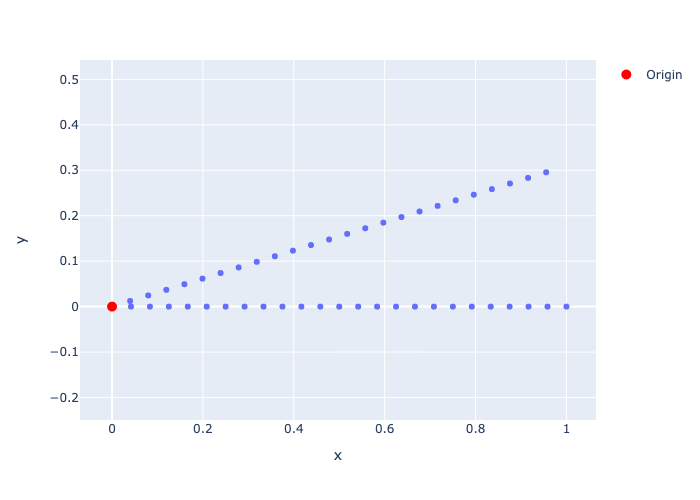

In [6]:
#| caption: Regular samples along 2 rays in 3D-space, projected on x-y plane.
#| label: fig:2-rays-regular-samples
fig=px.scatter(x=samples[...,0].flatten(), y=samples[...,1].flatten())
fig.add_scatter(x=[0], y=[0], mode='markers', marker=dict(color='red', size=10), name='Origin')
fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))

### Integration along Rays

```{index} opacity, transmittance
```
The second part of the volume rendering story is where the magic happens. Let us assume that we are given the above densities $\sigma_i$ and colors $c_i$ at $N$ sampled points $P_i$ on a ray corresponding to a given pixel. We can then calculate the color $C$ for the pixel using the equation below,
\begin{equation}
C = \sum_{i=1}^N \alpha_i T_i c_i
\end{equation}
where $\alpha_i$ is the **opacity** and $T_i$ is the **transmittance** at $P_i$, both defined below:
\begin{equation}\begin{aligned}
\alpha_i &\doteq 1 - \exp(-\sigma_i) \\
T_i &\doteq \exp ( - \sum_{j=1}^{i-1} \sigma_j).
\end{aligned}\end{equation}
The quantity $\alpha_i$ is the easier of the two to understand: a density $\sigma=0$ corresponds to an alpha value $\alpha=0$, signifying full transparency. Conversely, a high density $\sigma >> 0$ will yield an alpha value close to $\alpha=1$, i.e., fully opaque. The transmittance $T_i$, on the other hand, is computed over all samples up to the current sample $P_i$, and measures the *lack* of occlusion in the space between the $i^{th}$ sample and the ray origin. 

The calculation of $C$ above simulates how light is absorbed as it travels through a medium, and can even deal with semi-transparency such as smoke, flames, frosted windows, etc. It is a simplified version of the calculation in the original NeRF paper as we do not bother to deal with non-uniform sampling. The color $c_i$ at the $i^{th}$ sample will contribute a lot if there is not a lot of "stuff" between it and the origin (transmittance $T_i$ is high), *and* the local opacity $\alpha_i$ is high. Conversely, if either visibility from the origin is occluded (transmittance $T_i$ is low) *or* there is really nothing there (opacity $\alpha_i$ is low) then the sample will not contribute much to the pixel color $C$.

The function `render_along_ray` below implements this equation, again taking care that arbitrary batch dimensions are correctly handled. It also allows for specifying a background color that is composited with the rendered color in case the ray does not hit anything in the scene. We defined the default color `WHITE` in the preamble.

In [7]:
def render_along_ray(density, rgb, background=WHITE):
    """Compute the final rendered color given the density and RGB values."""
    alpha = 1 - torch.exp(-density)
    cumulative_density = torch.cumsum(density, dim=-1)
    trans = torch.exp(-cumulative_density)
    trans = torch.cat([torch.ones_like(density[..., :1]), trans[..., :-1]], dim=-1)

    weights = alpha * trans
    color_acc = torch.einsum('...i,...ij->...j', weights, rgb)
    acc = weights.sum(dim=-1, keepdim=True)

    return color_acc + (1.0 - acc) * background

We illustrate this volume rendering code below, using randomly generated `density` and `rgb` inputs that have the same shape as our sampled rays from above, demonstrating that we indeed get *two* RGB colors as the end-result:

In [8]:
density = torch.rand(2, 5) # Random density
rgb = torch.rand(2, 5, 3) # Random colors (between 0 and 1)
rendered = render_along_ray(density, rgb)
assert rendered.shape == torch.Size([2, 3])
print(rendered.detach().numpy())

[[0.6325107  0.73262054 0.477316  ]
 [0.46646896 0.81469035 0.5305866 ]]


Of course, because our inputs are random the result is also totally random! To remedy that we add the final piece of the puzzle below: a way to regress the densities and colors in a given volume from a set of input images.

## A Differentiable Voxel Grid

> A voxel grid of density or color.

A key decision in the NeRF architecture is how to represent the function $F_\Theta$ so it can be queried for a density and a color at every point. In short, we need:
\begin{equation}
(\sigma, c) = F_\Theta(P)
\end{equation}
with $P\in R^3$, $\sigma\in R$, and $c\in[0...255]^3$. Note that in computer vision, neural networks typically take high-dimensional inputs, e.g., entire images, so having such a low-dimensional input (3) is highly unusual. This "coordinate-based" approach is one of the breakthroughs of NeRF-style representations.

```{index} voxel grid
```
```{index} pair: multi-layer perceptron; MLP
```
We will use a **voxel grid** to represent $F_\Theta$. The original NeRF paper used a fully connected neural network, also called a multi-layer perceptron (MLP) that takes a 3D coordinate as input, and in some variants also a ray direction. In DVGO, a later and much faster method, the color and density are instead stored in a voxel grid, which is the approach we adopt. The key is to create a *differentiable* 3D interpolation scheme, that we can then *train* by asking it to predict the colors in the input images.

```{index} trilinear interpolation
```
We can build upon the 1D interpolation example that we introduced in Section 5.6. However, to represent 3D scenes we need to generalize it to 3D. In particular, the interpolation function has to be changed from simple linear interpolation over an interval, to **trilinear interpolation** on voxels. 
The code in Figure [4](#fig:rendering-along-ray) implements trilinear interpolation in the `Voxelgrid` class. The values on the *eight* corners of each voxel are combined using three blending weights, which depend on where the queried point lies within the voxel.

In [ ]:
#| caption: Rendering along a ray with random density and colors.
#| label: fig:rendering-along-ray
def bracket(x, n):
    """Return the indices of the nearest grid points to x, as well as weights."""
    # Check device of x and n:
    x0 = torch.floor(x).long()
    X0 = torch.clamp(x0, min=0, max=(n - 1))
    X1 = torch.clamp(x0 + 1, min=0, max=(n - 1))
    return X0, X1, torch.clamp(x - x0.float(), min=0.0, max=1.0)

def interpolate(v0, v1, alpha):
    """Interpolate between v0 and v1 using alpha, using unsqueeze to properly handle batches."""
    return v0 * (1 - alpha.unsqueeze(-1)) + v1 * alpha.unsqueeze(-1)

class VoxelGrid(nn.Module):
    def __init__(self, shape, d=1, max=1.0, fill=None):
        """A 3D voxel grid with given `shape` with learnable values at the middle of the voxels."""
        super(VoxelGrid, self).__init__()
        # Note that we store *corner* values, so we need one more point in each dimension:
        storage_shape = tuple(s + 1 for s in shape)
        if fill is not None:
            self.grid = nn.Parameter(fill.view(1, 1, 1, d).repeat(*storage_shape, 1))
        else:
           self.grid = nn.Parameter(torch.rand(*storage_shape, d, dtype=torch.float32) * max)

    def forward(self, P):
        """Implement trilinear interpolation at the points P."""
        x, y, z = P[..., 0], P[..., 1], P[..., 2]

        # Get indices of the corners, clamping to the grid size where needed:
        X0, X1, a = bracket(x, self.grid.shape[0])
        Y0, Y1, b = bracket(y, self.grid.shape[1])
        Z0, Z1, c = bracket(z, self.grid.shape[2])

        # Interpolate in the x direction:
        y0z0 = interpolate(self.grid[X0, Y0, Z0, :], self.grid[X1, Y0, Z0, :], a)
        y1z0 = interpolate(self.grid[X0, Y1, Z0, :], self.grid[X1, Y1, Z0, :], a)
        y0z1 = interpolate(self.grid[X0, Y0, Z1, :], self.grid[X1, Y0, Z1, :], a)
        y1z1 = interpolate(self.grid[X0, Y1, Z1, :], self.grid[X1, Y1, Z1, :], a)

        # Interpolate in the y direction:
        z0 = interpolate(y0z0, y1z0, b)
        z1 = interpolate(y0z1, y1z1, b)

        # Interpolate in the z direction:
        return interpolate(z0, z1, c).squeeze(-1)

A `VoxelGrid` instance effectively defines a parameterized function in 3D. When we query it, we need to provide 3D coordinates. For example, the code below initializes a voxel grid with random values, and then evaluates the a scalar function at a 3D point:

In [10]:
voxel_grid_module = VoxelGrid(shape=(6, 6, 6), d=1)
point = torch.Tensor([1.5, 2.7, 3.4])
output = voxel_grid_module(point)
print(f"Interpolated Output: {output.item():.5f}")

Interpolated Output: 0.65808


The code is carefully written so it can handle both arbitrary batches of inputs and multi-dimensional outputs.
As an example, below we create a grid that interpolates a three-dimensional function (`d=3`), like color, and evaluate it at a 2x2 batch `x` of 3D points:

In [11]:
voxel_grid_module = VoxelGrid(shape = (6, 6, 6), d=3, fill=BLUE)
x = torch.Tensor([[[1.5, 2.7, 3.4], [2.3, 4.6, 1.1]], [[2.3, 4.6, 1.1], [2.3, 4.6, 1.1]]])
y = voxel_grid_module(x)
print("Input shape:", x.shape)
print("Output shape:", y.shape)
print("Interpolated Output:\n", y.cpu().detach().numpy())

Input shape: torch.Size([2, 2, 3])
Output shape: torch.Size([2, 2, 3])
Interpolated Output:
 [[[0. 0. 1.]
  [0. 0. 1.]]

 [[0. 0. 1.]
  [0. 0. 1.]]]


Note we used a variant of the constructor that fills the grid with an initial value, here the color `BLUE` defined in the preamble.
Being able to handle large batches of points is crucial when training with stochastic gradient descent, as we saw before.
But when training a NeRF, we will also use the ability to have arbitrary input shapes for other purposes.

## DVGO

```{index} pair: Direct Voxel Grid Optimization; DVGO
```
We can now define a simple DVGO (Direct Voxel Grid Optimization by {cite:t}`Sun22cvpr_dvgo`) class that combines:

- sampling points $P$ along each ray;
- converting from scene coordinates into grid coordinates;
- retrieving density and color by interpolating in *two* voxel grids;
- volume rendering.

Each of these steps has a number of configurable parameters which you can experiment with:

In [12]:
@dataclass
class Config:
    near: float = 1.5
    far: float = 3.5
    num_samples: int = 64
    min_corner: tuple[float] = (-1.0, -1.0, 0.0)
    max_corner: tuple[float] = (1.0, 1.0, 1.0)
    shape: tuple[int] = (128, 128, 128)
    background = WHITE

The `SimpleDVGO` in Figure [5](#code:simple-dvgo) first pre-computes a number of things in the constructor, and then just has a fully differentiable `forward` method. 
Beyond sampling rays and volume rendering, which we discussed before, there are three new pieces:

- there is a rescaling step to go from scene to grid coordinates
- the output from the density voxel grid is put through a `relu` nonlinearity.
- the color is put through a `clamp` nonlinearity.

The latter two steps, which you can look up in pytorch’s documentation, are a differentiable way to ensure the output samples remain within their expected ranges. Note also that training a NeRF can take a long time, so we are careful to use `float32` everywhere, which takes less GPU resources.

We also need a `sample_rays` function that is used to sample points along the rays according to provided `t_values`. During training, it adds a small random scalar to the t_values to prevent overfitting to the discrete sampling locations.

In [ ]:
def sample_rays(t_values, rays, training=True):
    """Sample points along the rays. """
    # Extract ray origins and directions from rays
    origins = rays[..., :3].to(dtype=torch.float32)
    directions = rays[..., 3:].to(dtype=torch.float32)

    # Add a small random scalar to t_values during training
    if training:
        with torch.no_grad():
            n = t_values.size(0)
            random_scalar = (torch.rand(n, device=rays.device) - 0.5) / n
            actual_ts = t_values.clone() + random_scalar
    else:
        actual_ts = t_values.clone()

    # Sample along the ray
    return sample_along_ray(actual_ts, origins, directions)

In [ ]:
#| caption: A simplified DVGO algorithm for differentiable volume rendering.
#| label: code:simple-dvgo
class SimpleDVGO(nn.Module):
    def __init__(self, config: Config = Config()):
        """Initialize voxel grids and bounding box corners."""
        super().__init__()  # Calling the superclass's __init__ method

        # Initialize sampler parameters:
        self.depths = torch.linspace(config.near, config.far, config.num_samples + 1,
                                     dtype=torch.float32)
        self.register_buffer('t_values', 0.5 * (self.depths[1:] + self.depths[:-1]))

        # Set up conversion from scene coordinates to grid coordinates:
        self.register_buffer('min', torch.tensor(config.min_corner, dtype=torch.float32))
        self.register_buffer('max', torch.tensor(config.max_corner, dtype=torch.float32))
        self.register_buffer('shape', torch.tensor(config.shape, dtype=torch.float32))

        # Initialize color grid to blue:
        self.rgb_voxel_grid = VoxelGrid(config.shape, d=3, fill=BLUE)

        # Initialize density grid with very low density:
        self.density_voxel_grid = VoxelGrid(config.shape, d=1, fill=torch.full((), 0.001, dtype=torch.float32))

        # Finally, record background color for rendering:
        self.register_buffer('background', config.background)

    def forward(self, rays, training=True):
        """Perform volume rendering using the provided ray information."""
        samples = sample_rays(self.t_values, rays, training=training)

        # Rescale to fit within the grid
        rescaled = self.shape * (samples - self.min) / (self.max - self.min)

        # Query Density Voxel Grid
        density = torch.squeeze(self.density_voxel_grid(rescaled))
        density = F.relu(density)

        # Query RGB Voxel Grid
        rgb = torch.clamp(self.rgb_voxel_grid(rescaled), 0.0, 1.0)

        # Render
        return render_along_ray(density, rgb, self.background)

Let's give it a whirl below, calculating the colors for 32 random rays, each with their origin and direction stacked into a 6-vector, so the input batch size is $32 \times 6$, and we expect an output batch size of RGB colors, i.e., $32 \times 3$:

In [15]:
# Initialize renderer
dvgo = SimpleDVGO()
dvgo.to(DEVICE)

x_samples = torch.rand((32, 6)).to(DEVICE)
y_samples = dvgo(x_samples)
# Verify shape of the output
print("Output tensor shape:", y_samples.shape)

Output tensor shape: torch.Size([32, 3])


## A simulated dataset

<!-- <figure id="fig:stonehenge">
<img src="https://github.com/gtbook/robotics/blob/main/stonehenge/train/render47.png?raw=1" style="width:14cm" alt="">
<figcaption>One of the synthetically generated images from the stonehenge dataset.</figcaption>
</figure> -->

We will use a dataset generated by Stanford researchers {cite:p}`Adamkiewicz22ral_nerf_nav` using Blender, using a simple 3D model of the Stonehenge monument in England. The dataset was originally published as part of the [Stanford NeRF Navigation project](https://mikh3x4.github.io/nerf-navigation/), and consists of 500 images, split into 200 images for training, and then validation and tests sets of 150 images each. Figure [6](#fig:training-image) illustrates how to read the image into memory (using a function from the `stonehenge` module) and display it.

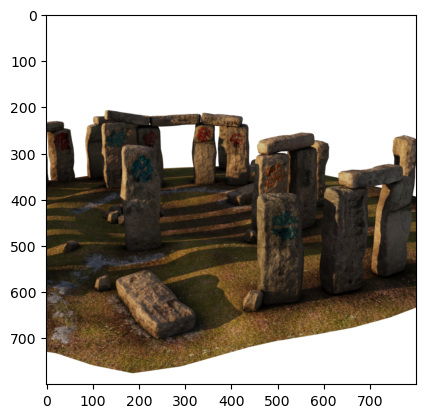

In [16]:
#| caption: An image from the training set.
#| label: fig:training-image
image = stonehenge.read_training_image(23)
plt.imshow(image);

Feel free to modify the index above and examine any of the other 198 images in the training set.

## Training a NeRF

Now that we have built the basic infrastructure to render a NeRF and regress it from data, let us apply it to real images. To do this, we will need two distinct pieces of information:

- the actual images themselves,
- accurate geometry from where the images were taken.

The latter is important because, as we saw above, a NeRF is trained with a set of *rays*. For a given image, every pixel in the image corresponds to a ray, and the *origin* of the ray is exactly the optical center of the camera. To calculate the *direction* of the ray need two pieces of information for each image:

- The *intrinsic* calibration of the camera, most importantly the focal length, tells us how to convert pixel coordinates into a direction in the camera coordinate frame.
- The *extrinsic* calibration, position and orientation from which the image was taken, is needed to transform directions in the camera frame into the scene coordinate frame.

Acquiring all this information for an arbitrary image sequence taken with some unknown, uncalibrated camera can be complicated. Cameras come in a variety of sizes and with very different lenses, and effects like radial distortion make the modeling process nontrivial. In addition, recovering the actual position and attitude of the camera in a scene is typically done through structure from motion, which can be time-consuming and tricky.

```{index} camera matrix
```

In the following, we will assume that all this hard work has been done for us, and/or the images have been simulated with exactly known camera parameters, both intrinsic and extrinsic. One popular way to accomplish this is by providing undistorted images accompanied by a $3 \times 4$ **camera matrix** $M$.
Recall from Section 5.3 that a 3D point $P$ can be projected into an image via
\begin{equation}
\tilde{p} = K R^T (P - t)
\end{equation}
where $\tilde{p}$ are *homogeneous* 2D image coordinates. We can re-write this as
\begin{equation}
\tilde{p} = M\tilde{P}
\end{equation}
where $\tilde{P} = \begin{bmatrix}P \\1 \end{bmatrix}$ and the camera matrix $M$ is given by
\begin{equation}
M = [A|a] = [K R^T | - K R^T t]
\end{equation}
That means that if we are *given* the camera matrix $M$ we can always recover the ray origins as 
\begin{equation}
t = -A^{-1} a
\end{equation}
and a random 3D point $P$ on the ray corresponding to $\tilde{p}$ as
\begin{equation}
P = A^{-1}(\tilde{p} - a)
\end{equation}
since $\tilde{p} = AP + a$. We will illustrate this below with the Stonehenge dataset.

### Creating Rays



The Stonehenge dataset came with its camera matrices: they were all written in a json file, which we can parse into a python dictionary:

In [17]:
# Open the local JSON file and read its content
data = data = stonehenge.load_json("transforms_train.json")

# Now, `data` contains the parsed JSON content.
print(data.keys())

dict_keys(['Far', 'Near', 'camera_angle_x', 'frames'])


The camera matrix associated with the image below can then be extracted by converting to `numpy`:

In [18]:
M = stonehenge.extract_camera_matrix(data, 47, (200,200))
print(M.shape)
print(M)

(3, 4)
[[ 2.88211427e+02  4.21953799e+00  6.38502181e+01 -2.50000011e+02]
 [-2.82206811e+01  9.63519126e+01  2.77633536e+02 -2.50000012e+02]
 [ 2.16327354e-01 -7.38591552e-01  6.38502181e-01 -2.50000005e+00]]


We can then calculate the ray origin and ray direction for any pixel. For expediency's sake, this is done in the `gtbook.stonehenge` library for us, and we can download the rays directly:

In [19]:
url = 'https://zenodo.org/records/10765346/files/training_rays-199-4.npz'
x_samples, y_samples = stonehenge.load_npz_from_url(url)  # takes a few seconds

# check that they have the right shape:
assert x_samples.shape == (199, 200, 200, 6)
assert y_samples.shape == (199, 200, 200, 3)

In [20]:
# Reshape the tensors and create a dataset
x_view = torch.from_numpy(x_samples).view(-1, x_samples.shape[-1])
y_view = torch.from_numpy(y_samples).view(-1, y_samples.shape[-1])
dataset = TensorDataset(x_view, y_view)

In Figure [7](#fig:300-rays) we show what a batch of 300 rays looks like, with the rendering volume shown as well.

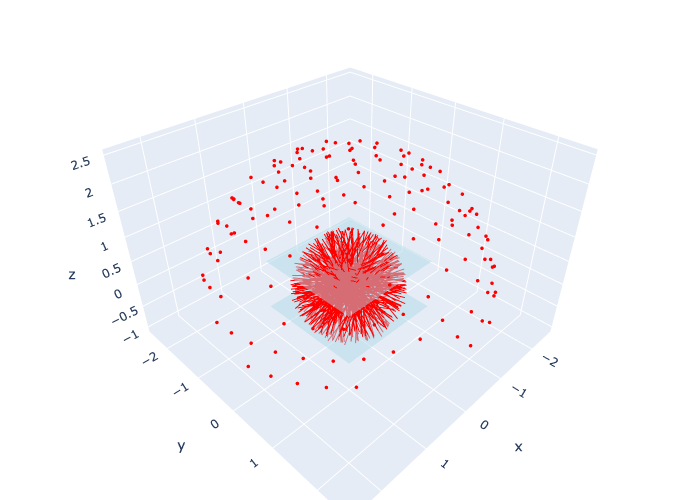

In [ ]:
#| caption: 300 rays from 199 cameras, along with the rendering volume.
#| label: fig:300-rays
data_loader = DataLoader(dataset, batch_size=300, shuffle=True)
data_iter = iter(data_loader)
x_batch, y_batch = next(data_iter)
assert x_batch.shape == torch.Size([300, 6])
assert y_batch.shape == torch.Size([300, 3])
fig = go.Figure()
for i in range(300):
    T = x_batch[i,:3]
    D = x_batch[i,3:]
    # Print devices for three params:
    samples = sample_along_ray(dvgo.t_values.cpu(), T, D)

    # Adding line segments for each ray
    fig.add_trace(
        go.Scatter3d(
            x=samples[:, 0],
            y=samples[:, 1],
            z=samples[:, 2],
            mode="lines",
            line=dict(color="red"),
        )
    )
    fig.add_trace(
        go.Scatter3d(
            x=[T[0].item()],
            y=[T[1].item()],
            z=[T[2].item()],
            mode="markers",
            marker=dict(color="red", size=2),
        )
    )

# add a cuboid from -1 to 1 in x and y, and 0 to 0.5 in z:
fig.add_trace(
    go.Mesh3d(
        x=[-1, 1, 1, -1, -1, 1, 1, -1],
        y=[-1, -1, 1, 1, -1, -1, 1, 1],
        z=[-0.5, -0.5, -0.5, -0.5, 0.5, 0.5, 0.5, 0.5],
        i=[0, 0, 4, 4],
        j=[1, 2, 5, 6],
        k=[2, 3, 6, 7],
        opacity=0.5,
        color="lightblue",
    )
)

fig.update_layout(showlegend=False, margin=dict(l=0, r=0, b=0, t=0));
fig.show()

### Training Loop

Let us recall the training code from Chapter 5. We previously used this code to train for the parameters of a 1D interpolation grid, minimizing a Mean-Squared Error (MSE) loss function, i.e., the squared difference between the predicted values and the training data values. This is the standard loss function for continuous *regression* problems.

In [24]:
def train_sgd(model, dataset, callback=None, learning_rate=0.01, num_epochs=10, batch_size=4096):
    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader for batch processing
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the built-in Mean-Squared Error loss function
    mse = nn.MSELoss()

    # Loop over the dataset multiple times (each loop is an epoch)
    iteration = 0
    for epoch in range(num_epochs):
        for x_batch, y_batch in data_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch.to(DEVICE))
            loss = mse(y_pred, y_batch.to(DEVICE))
            loss.backward()
            optimizer.step()

            if callback is not None:
                callback(epoch, iteration, loss.item())

            iteration += 1

In [25]:
# Initialize your SimpleDVGO model
base = 128
config = Config(
    near=1.0,
    far=4.0,
    num_samples=base,
    min_corner=(-1.5, -1.5, -1.5),
    max_corner=(1.5, 1.5, 1.5),
    shape=(base-1, base-1, base-1)
)

model = SimpleDVGO(config).to(DEVICE)

Now we could train, with the code shown below. However, training takes a bit of time, so if you execute this code in colab it could mean waiting quite a bit, depending on the compute you have available. To avoid this, we pre-trained a model for you for 5 epochs, which took around 18 minutes with the compute available at the time. We uploaded a checkpoint to the file-sharing site Zenodo {cite}`DvgoChecpoint5Epochs`, and we load it into memory below. If you want to train with your own parameters or simply re-do the training, you can open the notebook and set `use_pretrained` to False below.

In [26]:
# if True, use the pre-trained model, else train a new model
use_pretrained = True
if use_pretrained:
    # Load the pre-trained model
    model_url = "https://zenodo.org/records/10767234/files/simple_dvgo-5-epochs.pt"
    model.load_state_dict(torch.hub.load_state_dict_from_url(model_url, map_location=DEVICE, progress=False))
else:
    # Create a callback that saves loss to a dataframe
    loss_data = pd.DataFrame(columns=['Iteration', 'Loss'])
    def record_loss(epoch:int, iteration:int, loss:float):
        if iteration % 100 != 0:
            return
        print(f"Epoch: {epoch}, iteration {iteration}: {loss:.5f}")
        loss_data.loc[len(loss_data)] = [iteration, loss]

    # Run the training loop
    train_sgd(model, dataset, callback=record_loss, num_epochs=5, batch_size=1024, learning_rate=0.01)
    px.line(loss_data, x='Iteration', y='Loss').show()

<figure id="fig:NeRF-loss"> 
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures7/loss-5-epochs.png?raw=1" style="width:90%" alt="">
<figcaption>Training loss for SimpleDVGO training run over 5 epochs.</figcaption>
</figure>

The training loss curve is shown in Figure [8](#fig:NeRF-loss). Note that, since we used 199 images and down-sampled the images by a factor of 4, each epoch corresponds to $200\times 200\times 199\approx 8M$ rays. Given that the batch size used was 1024, this corresponds to approximately 7,800 iterations per epoch, or 39,000 iterations in total for 5 epochs. The loss drops dramatically in the first few iterations, but even after 5 epochs the loss is slowly but steadily declining.

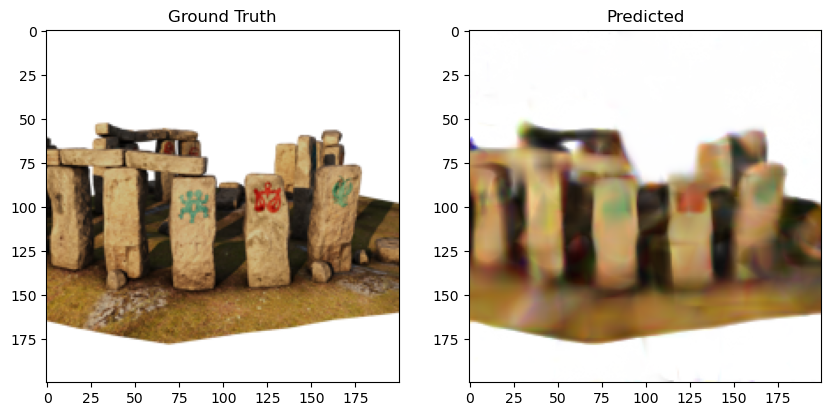

In [27]:
#| caption: Comparison between training image and rendered image.
#| label: fig:training-vs-rendered
i = 60; predicted = model(torch.from_numpy(x_samples[i]).to(DEVICE), training=False)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(y_samples[i])
ax[0].set_title("Ground Truth")
ax[1].imshow(np.clip(predicted.detach().cpu().numpy(), 0, 1))
ax[1].set_title("Predicted");

A rendering from the model is compared with a ground truth image in Figure [9](#fig:training-vs-rendered). The predicted image is still quite blurry compared to the ground truth image, because our voxel grid is fairly coarse. In addition, in an effort to keep the code simple, we did not include many improvements to the ray sampling and rendering equations that have appeared in the literature, which would also improve results. But the figure illustrates that even this basic code works quite well.

In figure [10](#fig:20-predicted) we rendered the predictions for 20 of the 199 training images for further comparison.

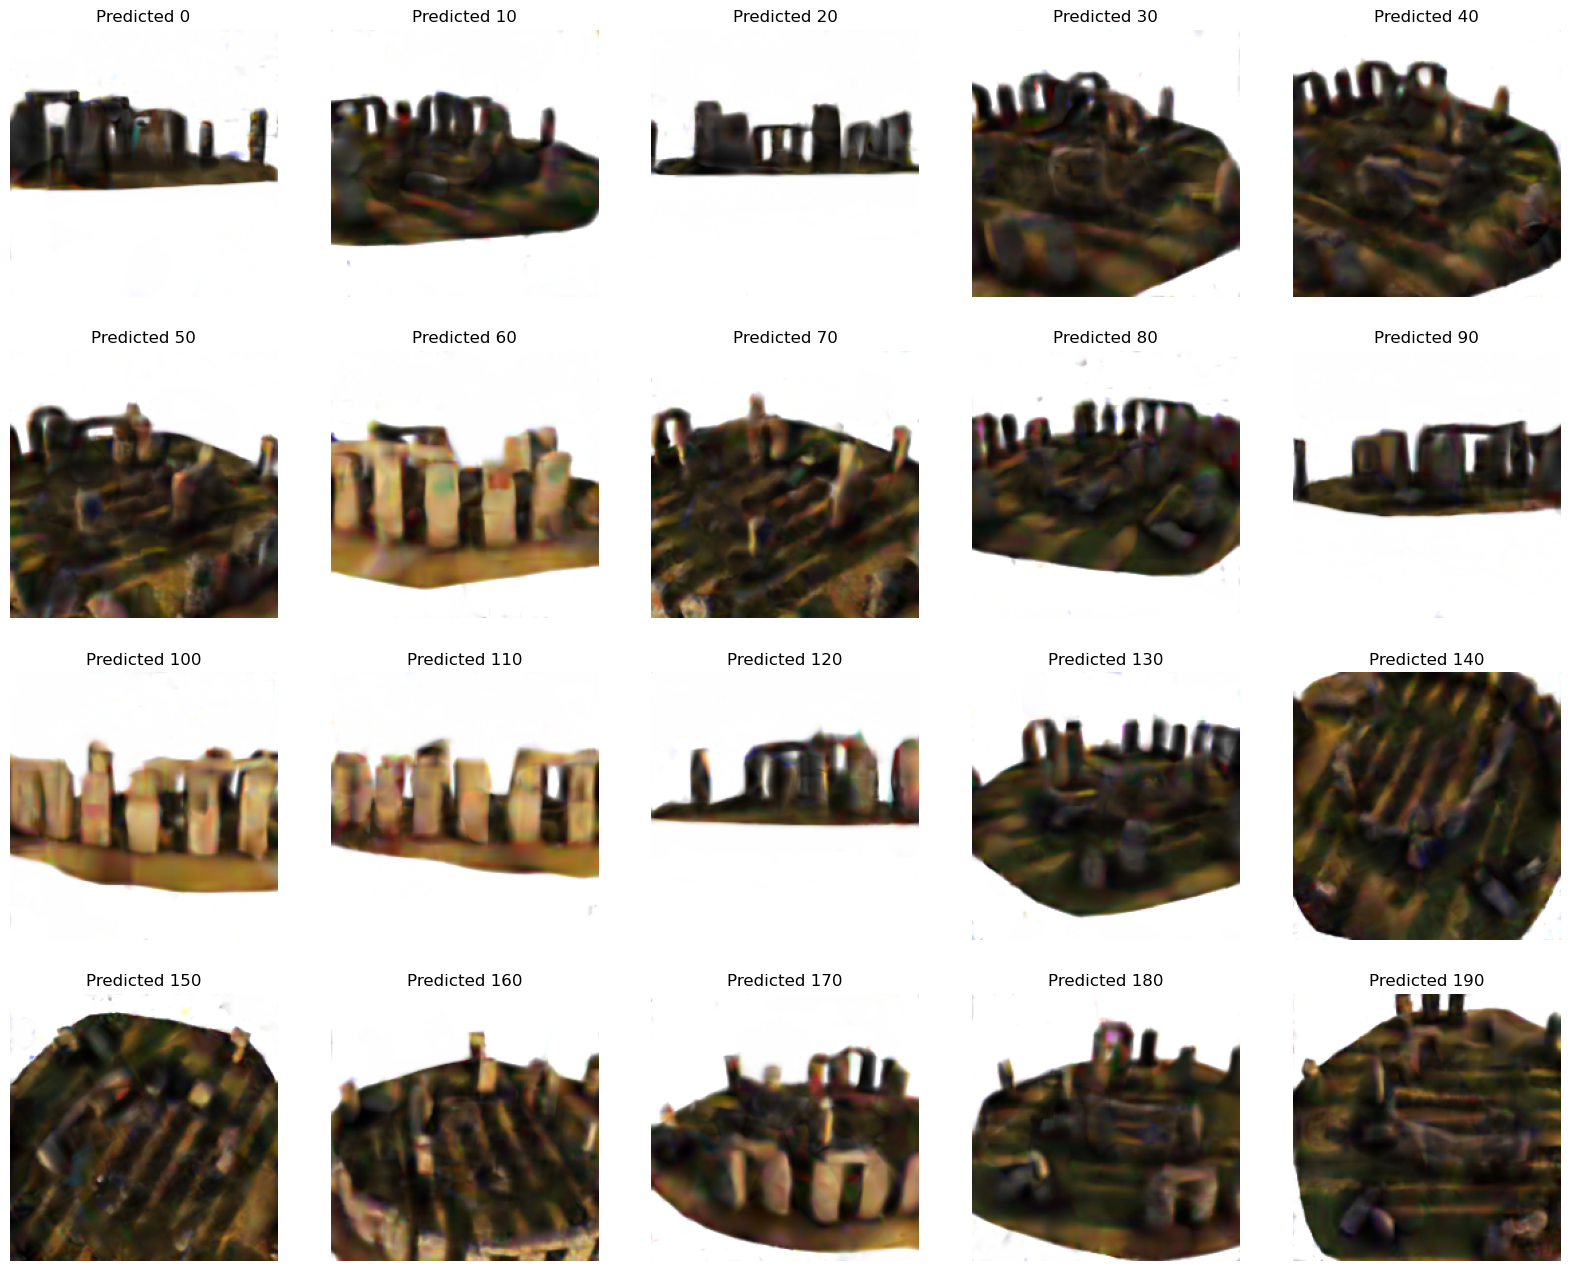

In [28]:
#| caption: every 10th image in a 5x4 grid.
#| label: fig:20-predicted
fig, ax = plt.subplots(4, 5, figsize=(20, 16))
for i in range(20):
    predicted = model(torch.from_numpy(x_samples[i*10]).to(DEVICE), training=False)
    ax[i//5, i%5].imshow(np.clip(predicted.detach().cpu().numpy(), 0, 1))
    ax[i//5, i%5].set_title(f"Predicted {i*10}")
    ax[i//5, i%5].axis('off')

## Radiance Fields for Visual Navigation

> We can take this one step further...

The above shows how neural radiance fields represent a radical new way to learn scene representations, using a *differentiable* volume rendering scheme. One can take this one step further and use the underlying density fields, combined with the motion planning techniques from the previous section, to enable unmanned aerial vehicles to navigate autonomously in new environments. If you want to see how this is done, you can read the 2022 Stanford paper by {cite:t}`Adamkiewicz22ral_nerf_nav` that inspired this section.
<!-- And to see it in action, you can visit their [project page](https://mikh3x4.github.io/nerf-navigation/) with videos and simulations. -->